In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
import torch
import torch.utils.data as data
import torchnet as tnt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import os
import json
import pickle as pkl
import pprint
import time


PATH_AUG = 'augs'
sys.path.append( PATH_AUG )
import augmentation
import cutmix
import cutout
import mixup
import random_shif
import windowwarp
import get_augs

In [2]:
print(torch.cuda.device_count())

1


In [3]:


def augs(BATCH_SIZE, SHAPE, DO_PROB, element_prob):

    mix_up = mixup.Mixup(batch_size = BATCH_SIZE,
        do_prob = DO_PROB,
        sequence_shape = SHAPE[1:],
        linear_mix_min = 0.1,
        linear_mix_max = 0.5)

    cut_mix = cutmix.Cutmix(batch_size = BATCH_SIZE,
            do_prob = DO_PROB,
            sequence_shape = SHAPE[1:],
            min_cutmix_len = SHAPE[1] // 2,
            max_cutmix_len = SHAPE[1],
            channel_replace_prob = element_prob,
            )

    cut_mix.batch = BATCH_SIZE
    cut_out = cutout.Cutout(
            batch_size = BATCH_SIZE,
            do_prob = DO_PROB,
            sequence_shape = SHAPE[1:],
            min_cutout_len = SHAPE[1] // 2,
            max_cutout_len = SHAPE[1],
            channel_drop_prob = element_prob,
    )
    
    return mix_up, cut_out, cut_mix

def batch_aug(x, y, mix_up, cut_out, cut_mix):
    example = {'input': x, 'target': y}
    example = cut_mix(example)
    example = cut_out(example)
    example = mix_up(example)
    x, y = example['input'], example['target']
    return x, y

In [4]:
PATH_TO_PASTIS = './PASTIS'
PATH_TO_PAPS = './utae-paps/'
sys.path.append(PATH_TO_PAPS)

In [5]:
#pastis import
#from dataloader import PASTIS_Dataset
#from collate import pad_collate

#model import
import src.model_utils
from src.backbones.utae import UTAE
from src.learning.miou import *
from src.learning.weight_init import *
from src import utils

from src.dataset import *

In [6]:
#pastis function

cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [21]:
def iterate( model, data_loader, criterion, config, optimizer=None, mode="train", device=None ):
    loss_meter = tnt.meter.AverageValueMeter()
    iou_meter = IoU(
        num_classes=config[ 'num_classes' ],
        ignore_index=config[ 'ignore_index' ],
        cm_device=config[ 'device' ],
    )

    t_start = time.time()
    for i, batch in enumerate(data_loader):
        
        
        
        if device is not None:
            batch = recursive_todevice(batch, device)
        (x, dates), y = batch
        y = y.long()

        if mode != "train":
            with torch.no_grad():
                out = model(x, batch_positions=dates)
        else:
            optimizer.zero_grad()
            out = model(x, batch_positions=dates)
        

        loss = criterion(out, y)
        if mode == "train":
            loss.backward()
            optimizer.step()
          
        #print( out.shape, y.shape )

        with torch.no_grad():
            pred = out.argmax(dim=1)
        iou_meter.add(pred, y)
        loss_meter.add(loss.item())

        if (i + 1) % config[ 'display_step' ] == 0:
            miou, acc = iou_meter.get_miou_acc()
            print(
                "Step [{}/{}], Loss: {:.4f}, Acc : {:.2f}, mIoU {:.2f}".format(
                    i + 1, len(data_loader), loss_meter.value()[0], acc, miou
                )
            )

    t_end = time.time()
    total_time = t_end - t_start
    print("Epoch time : {:.1f}s".format(total_time))
    miou, acc = iou_meter.get_miou_acc()
    metrics = {
        "{}_accuracy".format(mode): acc,
        "{}_loss".format(mode): loss_meter.value()[0],
        "{}_IoU".format(mode): miou,
        "{}_epoch_time".format(mode): total_time,
    }

    if mode == "test":
        return metrics, iou_meter.conf_metric.value()  # confusion matrix
    else:
        return metrics


def recursive_todevice(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    elif isinstance(x, dict):
        return {k: recursive_todevice(v, device) for k, v in x.items()}
    else:
        return [recursive_todevice(c, device) for c in x]


def prepare_output(config):
    os.makedirs(config[ 'res_dir' ], exist_ok=True)
    for fold in range(1, 6):
        os.makedirs(os.path.join(config[ 'res_dir' ], "Fold_{}".format(fold)), exist_ok=True)


def checkpoint(fold, log, config):
    with open(
        os.path.join(config[ 'res_dir' ], "Fold_{}".format(fold), "trainlog.json"), "w"
    ) as outfile:
        json.dump(log, outfile, indent=4)


def save_results(fold, metrics, conf_mat, config):
    with open(
        os.path.join(config[ 'res_dir' ], "Fold_{}".format(fold), "test_metrics.json"), "w"
    ) as outfile:
        json.dump(metrics, outfile, indent=4)
    pkl.dump(
        conf_mat,
        open(
            os.path.join(config[ 'res_dir' ], "Fold_{}".format(fold), "conf_mat.pkl"), "wb"
        ),
    )


def overall_performance(config):
    cm = np.zeros((config[ 'num_classes' ], config[ 'num_classes' ]))
    for fold in range(1, 6):
        cm += pkl.load(
            open(
                os.path.join(config[ 'res_dir' ], "Fold_{}".format(fold), "conf_mat.pkl"),
                "rb",
            )
        )

    if config.ignore_index is not None:
        cm = np.delete(cm, config[ 'ignore_index' ], axis=0)
        cm = np.delete(cm, config[ 'ignore_index' ], axis=1)

    _, perf = confusion_matrix_analysis(cm)

    print("Overall performance:")
    print("Acc: {},  IoU: {}".format(perf["Accuracy"], perf["MACRO_IoU"]))

    with open(os.path.join(config[ 'res_dir' ], "overall.json"), "w") as file:
        file.write(json.dumps(perf, indent=4))



In [8]:
pad_collate = lambda x: utils.pad_collate(x, pad_value = 0)

fold_sequence = [[1, 2], [1], [5]]
fold = 0

pastis_train_dataset = PASTIS_Dataset(PATH_TO_PASTIS, folds = fold_sequence[ 0 ],  norm=True, target='semantic')
pastis_test_dataset  = PASTIS_Dataset(PATH_TO_PASTIS, folds = fold_sequence[ 1 ], norm=True, target='semantic')
pastis_eval_dataset = PASTIS_Dataset(PATH_TO_PASTIS, folds = fold_sequence[ 2 ], norm=True, target='semantic')

print( len(pastis_train_dataset) )
print( len(pastis_test_dataset) )
print( len(pastis_eval_dataset) )

train_loader = torch.utils.data.DataLoader(pastis_train_dataset, batch_size=2, collate_fn=pad_collate, shuffle=True)
test_loader = torch.utils.data.DataLoader(pastis_test_dataset, batch_size=2, collate_fn=pad_collate, shuffle=True)
evaluate_loader = torch.utils.data.DataLoader(pastis_eval_dataset, batch_size=2, collate_fn=pad_collate, shuffle=True)


Reading patch metadata . . .


/home/antoine/Bureau/DataAugmentation/./utae-paps/src/dataset.py:102: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for pid, date_seq in dates.iteritems():


Done.
Dataset ready.
Reading patch metadata . . .


/home/antoine/Bureau/DataAugmentation/./utae-paps/src/dataset.py:102: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for pid, date_seq in dates.iteritems():


Done.
Dataset ready.
Reading patch metadata . . .


/home/antoine/Bureau/DataAugmentation/./utae-paps/src/dataset.py:102: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for pid, date_seq in dates.iteritems():


Done.
Dataset ready.
981
487
496


In [18]:
config = {}
config[ 'epoch' ] = 100
config[ 'num_classes' ] = 20
config[ 'val_after' ] = 0 #nb epoch avant premiere validation
config[ 'val_every' ] = 1 #nb epoch entre chaque validation
config[ 'device' ] = 'cuda'
config[ 'ignore_index' ] = -1
config[ 'display_step' ] = 50
config[ 'res_dir' ] = './results'
config[ 'model' ] = 'utae'

torch.cuda.empty_cache()
device = config[ 'device' ]

prepare_output(config)

In [10]:
cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,19)]+['w']
cmap = ListedColormap( colors = cus_colors, name='agri',N = 20 )

label_names = [
"Background",
"Meadow",
"Soft winter wheat",
"Corn",
"Winter barley",
"Winter rapeseed",
"Spring barley",
"Sunflower",
"Grapevine",
"Beet",
 "Winter triticale",
 "Winter durum wheat",
 "Fruits,  vegetables, flowers",
 "Potatoes",
 "Leguminous fodder",
 "Soybeans",
 "Orchard",
 "Mixed cereal",
 "Sorghum",
 "Void label" ]

def get_rgb(x,b=0,t_show=6):
    """Gets an observation from a time series and normalises it for visualisation."""
    im = x[b,t_show,[2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im


    

In [28]:
model_naugs = UTAE(
        input_dim = 10,
        encoder_widths = [ 64, 64, 64, 128 ],
        decoder_widths = [ 32, 32, 64, 128 ],
        out_conv = [ 32, 20 ],
        str_conv_k = 4,
        str_conv_s = 2,
        str_conv_p = 1,
        agg_mode = "att_group",
        encoder_norm = "group",
        n_head = 16,
        d_model = 256,
        d_k = 4,
        encoder = False,
        return_maps = False,
        pad_value = 0,
        padding_mode = "reflect",
    )

model_augs = UTAE(
        input_dim = 10,
        encoder_widths = [ 64, 64, 64, 128 ],
        decoder_widths = [ 32, 32, 64, 128 ],
        out_conv = [ 32, 20 ],
        str_conv_k = 4,
        str_conv_s = 2,
        str_conv_p = 1,
        agg_mode = "att_group",
        encoder_norm = "group",
        n_head = 16,
        d_model = 256,
        d_k = 4,
        encoder = False,
        return_maps = False,
        pad_value = 0,
        padding_mode = "reflect",
    )


sd = torch.load( os.path.join( "results" ,"no_augs", "model.pth.tar"), map_location=device )
model_naugs.load_state_dict(sd["state_dict"])

sd = torch.load( os.path.join( "results" ,"augs", "model.pth.tar"), map_location=device )
model_augs.load_state_dict(sd["state_dict"])

<All keys matched successfully>

run a model on all the data

In [30]:

model_naugs = model_naugs.to( device )
model_augs = model_augs.to( device )

#test sans augmentations
optimizer = torch.optim.Adam( model_naugs.parameters(), lr = 0.001 )
weights = torch.ones( config[ 'num_classes' ], device = device ).float()
criterion = torch.nn.CrossEntropyLoss( weight = weights )

test_metrics, conf_mat = iterate(
    model_naugs,
    data_loader=test_loader,
    criterion=criterion,
    config=config,
    optimizer=optimizer,
    mode="test",
    device=device,
)

print("Without augmentation")
print(
    "Loss {:.4f},  Acc {:.2f},  IoU {:.4f}".format(
        test_metrics["test_loss"],
        test_metrics["test_accuracy"],
        test_metrics["test_IoU"],
    )
)

save_results(1, test_metrics, conf_mat.cpu().numpy(), config)

#tests avec augmentations
optimizer = torch.optim.Adam( model_augs.parameters(), lr = 0.001 )
weights = torch.ones( config[ 'num_classes' ], device = device ).float()
criterion = torch.nn.CrossEntropyLoss( weight = weights )
test_metrics, conf_mat = iterate(
    model_augs,
    data_loader=test_loader,
    criterion=criterion,
    config=config,
    optimizer=optimizer,
    mode="test",
    device=device,
)
print("With augmentation")
print(
    "Loss {:.4f},  Acc {:.2f},  IoU {:.4f}".format(
        test_metrics["test_loss"],
        test_metrics["test_accuracy"],
        test_metrics["test_IoU"],
    )
)


save_results(2, test_metrics, conf_mat.cpu().numpy(), config)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

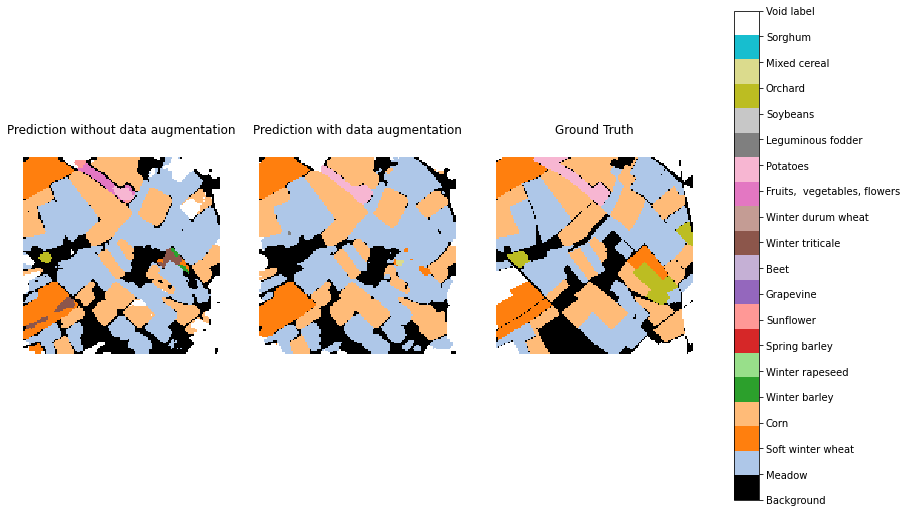

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
pastis_test_dataset[ 0 ]

test_loader = torch.utils.data.DataLoader(pastis_train_dataset, batch_size=1, collate_fn=pad_collate, shuffle=True)

for i in range(5):
    (d, t), b = test_loader.__iter__().__next__()

    with torch.no_grad():
        predicted_naugs = model_naugs( d, batch_positions = t)
        pred_augs = model_augs( d, batch_positions = t )
    pred_naugs = predicted_naugs.argmax(dim=1)
    pred_augs = pred_augs.argmax(dim=1)

    figure, axis = plt.subplots(1, 3, figsize=(15, 15))

    axis[ 0 ].matshow( pred_naugs[0], cmap=cmap )
    axis[ 0 ].set_title("Prediction without data augmentation")
    axis[ 0 ].axis('off')

    axis[ 1 ].matshow( pred_augs[0], cmap = cmap )
    axis[ 1 ].set_title("Prediction with data augmentation")
    axis[ 1 ].axis('off')

    pcm = axis[ 2 ].matshow( b[0], cmap = cmap )
    axis[ 2 ].set_title("Ground Truth")
    axis[ 2 ].axis('off')

    cbar = figure.colorbar(pcm, ax=axis[:], shrink=0.6, location='right')
    cbar.ax.set_yticks([i for i in range(0,20)])
    cbar.ax.set_yticklabels(label_names)

<AxesSubplot: >

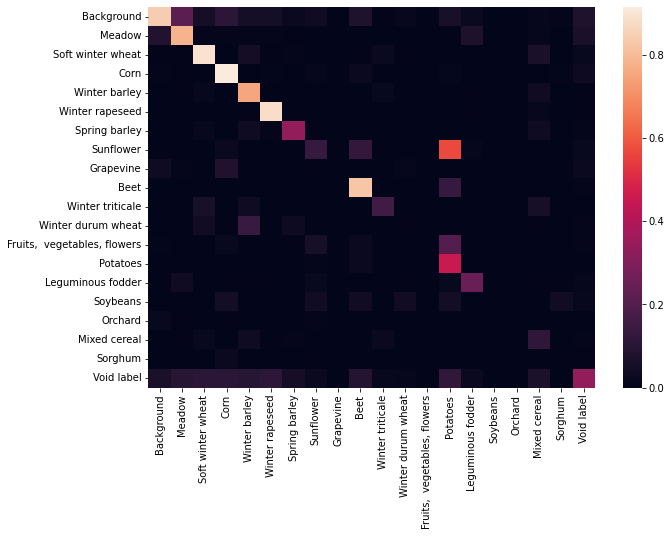

In [34]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

confusion = np.load( os.path.join( "results" ,"augs", "conf_mat.pkl"), allow_pickle = True )

confusion = confusion / confusion.astype(float).sum(axis=1)

df_cm = pd.DataFrame(confusion, index = label_names,
                  columns = label_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=False)

# Tests des augmentations 

In [15]:
PATH_AUG = 'augs'
sys.path.append( PATH_AUG )

import augmentation
import cutmix
import cutout
import mixup
import random_shif
import windowwarp
import get_augs

In [16]:
(d, t), b = test_loader.__iter__().__next__()

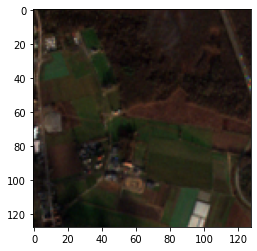

In [17]:
im = get_rgb( d )

plt.imshow( im )

In [18]:
SHAPE = d.shape
print( d.shape )
t = cutmix.Cutmix(batch_size = 2,
                  do_prob = 0.5,
                  sequence_shape = SHAPE[1:],
                  min_cutmix_len = SHAPE[1] // 2,
                  max_cutmix_len = SHAPE[1],
                  channel_replace_prob = 0.5,
                  )

torch.Size([1, 38, 10, 128, 128])


In [19]:
ddi = { "input": d, "target": b }
trans = t( ddi )


/home/antoine/Bureau/Projet_TdS/augs/cutmix.py:74: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  time = torch.range(0, self.sequence_shape[0] - 1, dtype=torch.float32)


In [35]:
import json
with open(os.path.join( "results" ,"augs", "trainlog.json"), 'r') as fcc_file:
    fcc_data = json.load(fcc_file)
    print(fcc_data)

{'1': {'train_accuracy': 50.09940266609192, 'train_loss': 2.605184629347076, 'train_IoU': 8.68716835975647, 'train_epoch_time': 400.67755460739136, 'val_accuracy': 68.8849925994873, 'val_loss': 1.9908088714845724, 'val_IoU': 15.537910163402557, 'val_epoch_time': 70.43367004394531}, '2': {'train_accuracy': 58.76006484031677, 'train_loss': 2.15488156403155, 'train_IoU': 12.164434790611267, 'train_epoch_time': 391.85972356796265, 'val_accuracy': 70.92232704162598, 'val_loss': 1.6329637852407268, 'val_IoU': 19.14425492286682, 'val_epoch_time': 71.42869114875793}, '3': {'train_accuracy': 61.00996732711792, 'train_loss': 1.9089301899834221, 'train_IoU': 14.748144149780273, 'train_epoch_time': 379.3551661968231, 'val_accuracy': 72.77068495750427, 'val_loss': 1.472894455877042, 'val_IoU': 23.372893035411835, 'val_epoch_time': 56.08900332450867}, '4': {'train_accuracy': 63.57770562171936, 'train_loss': 1.7404730426803872, 'train_IoU': 16.71960949897766, 'train_epoch_time': 372.67835783958435, '

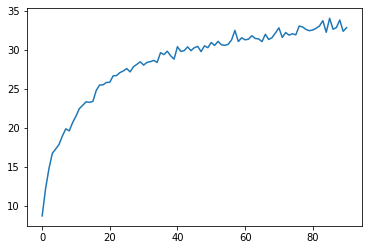

In [36]:
loss = []
for i in range(1, 92):
    loss.append( fcc_data[str(i)]['train_IoU'])
loss = np.asarray( loss )
plt.plot( loss )
plt.show()